In [1]:
from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

import tensorflow as tf

from tensorflow.keras.datasets import mnist


In [2]:
#Load MNIST data

dataset_name = "mnist_3_vs_5"

img_rows, img_cols = 28, 28

num_classes = 10
batch_size = 32

included_classes = { 3, 5 }

(x_train, y_train), (x_test, y_test) = mnist.load_data()

keep_index_train = []
for i in range(y_train.shape[0]) :
    if y_train[i] in included_classes :
        keep_index_train.append(i)

keep_index_test = []
for i in range(y_test.shape[0]) :
    if y_test[i] in included_classes :
        keep_index_test.append(i)

x_train = x_train[keep_index_train]
x_test = x_test[keep_index_test]
y_train = y_train[keep_index_train]
y_test = y_test[keep_index_test]

n_train = int((x_train.shape[0] // batch_size) * batch_size)
n_test = int((x_test.shape[0] // batch_size) * batch_size)
x_train = x_train[:n_train]
x_test = x_test[:n_test]
y_train = y_train[:n_train]
y_test = y_test[:n_test]


x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print("x_train.shape = " + str(x_train.shape))

print("n train samples = " + str(x_train.shape[0]))
print("n test samples = " + str(x_test.shape[0]))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

#Binarize images

def _binarize_images(x, val_thresh=0.5) :
    
    x_bin = np.zeros(x.shape)
    x_bin[x >= val_thresh] = 1.
    
    return x_bin

x_train = _binarize_images(x_train, val_thresh=0.5)
x_test = _binarize_images(x_test, val_thresh=0.5)

#Add padding to images
padding = 2

x_train_padded = np.concatenate([
    np.zeros((x_train.shape[0], x_train.shape[1] + 4, 2, 1)),
    np.concatenate([
        np.zeros((x_train.shape[0], 2, x_train.shape[2], 1)),
        x_train,
        np.zeros((x_train.shape[0], 2, x_train.shape[2], 1))
    ], axis=1),
    np.zeros((x_train.shape[0], x_train.shape[1] + 4, 2, 1))
], axis=2)

x_test_padded = np.concatenate([
    np.zeros((x_test.shape[0], x_test.shape[1] + 4, 2, 1)),
    np.concatenate([
        np.zeros((x_test.shape[0], 2, x_test.shape[2], 1)),
        x_test,
        np.zeros((x_test.shape[0], 2, x_test.shape[2], 1))
    ], axis=1),
    np.zeros((x_test.shape[0], x_test.shape[1] + 4, 2, 1))
], axis=2)


x_train.shape = (11552, 28, 28, 1)
n train samples = 11552
n test samples = 1888


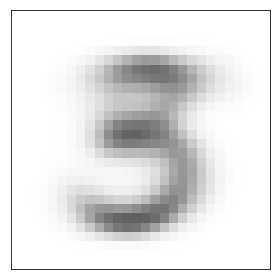

In [3]:
#Visualize background image distribution

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 3)) + pseudo_count) / (x_train.shape[0] + pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))

f = plt.figure(figsize=(4, 4))

plot_ix = 0

plt.imshow(x_mean, cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()
plt.show()


In [4]:
from sal.saliency_model import SaliencyModel, get_black_box_fn
from sal.utils.resnet_encoder_mnist import resnet50encoder

model_save_str = "pytorch_saliency_model_mnist_3_vs_5_smaller_blur_resnet50_n_epochs_phase1_0_phase2_20"

saliency = SaliencyModel(resnet50encoder(pretrained_f=None, num_classes=10), 5, 64, 3, 64, fix_encoder=False, use_simple_activation=False, allow_selector=False, num_classes=10)
saliency.restore(model_save_str)


In [5]:
#Create pytorch input tensor

x_test_padded_pytorch = Variable(torch.FloatTensor(np.transpose(x_test_padded, (0, 3, 1, 2))))
x_test_padded_pytorch = x_test_padded_pytorch.cuda()

digit_test = np.array(np.argmax(y_test, axis=1), dtype=np.int)

device = torch.device('cuda:0')

saliency.to(device)
x_test_padded_pytorch = x_test_padded_pytorch.to(device)


In [6]:

n_batches = x_test.shape[0] // batch_size

masks_padded = []

with torch.no_grad() :
    for batch_ix in range(n_batches) :

        x_batch = x_test_padded_pytorch[batch_ix * batch_size:(batch_ix + 1) * batch_size, ...]

        mask_batch = saliency(x_batch)[0]

        if mask_batch.size()[-2:] != x_batch.size()[-2:]:
            mask_batch = F.upsample(mask_batch, (x_batch.size(2), x_batch.size(3)), mode='bilinear')
        
        mask_batch = mask_batch.cpu().numpy()
        
        masks_padded.append(mask_batch)

masks_padded = np.concatenate(masks_padded, axis=0)
masks_padded = np.transpose(masks_padded, (0, 2, 3, 1))

masks = masks_padded[:, padding:-padding, padding:-padding, :]

print("masks.shape = " + str(masks.shape))


/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


masks.shape = (1888, 28, 28, 1)


In [7]:

def _unpool(masks, unpool_factor=2) :
    
    masks_unpooled = np.zeros((masks.shape[0], masks.shape[1] * unpool_factor, masks.shape[2] * unpool_factor, 1))
    
    for i in range(masks_unpooled.shape[1]) :
        for j in range(masks_unpooled.shape[2]) :
            masks_unpooled[:, i, j, 0] = masks[:, i // unpool_factor, j // unpool_factor, 0]

    return masks_unpooled

importance_scores_test = _unpool(masks, unpool_factor=1)


Test image 0:


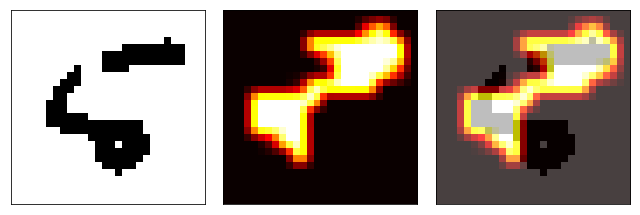

Test image 1:


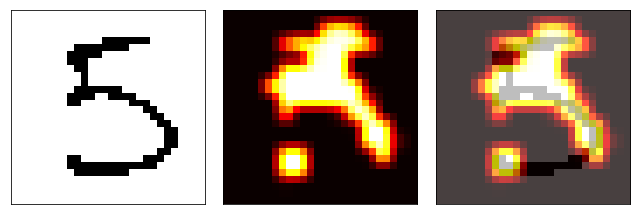

Test image 2:


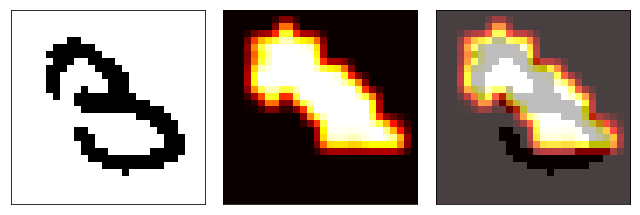

Test image 3:


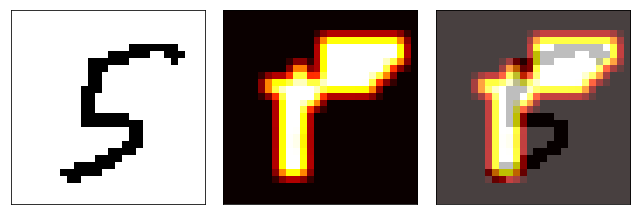

Test image 4:


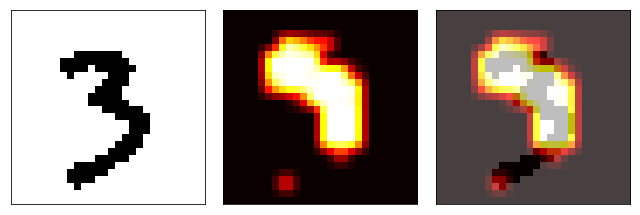

Test image 5:


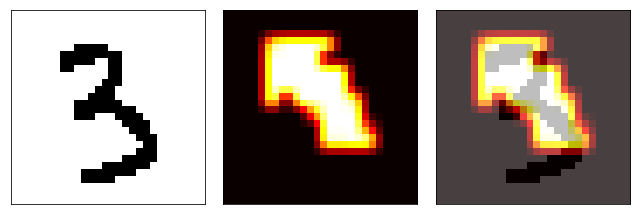

Test image 6:


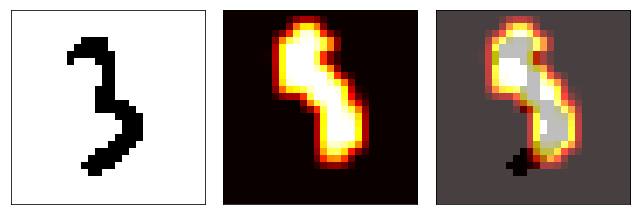

Test image 7:


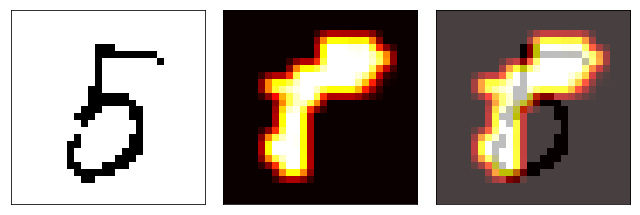

Test image 8:


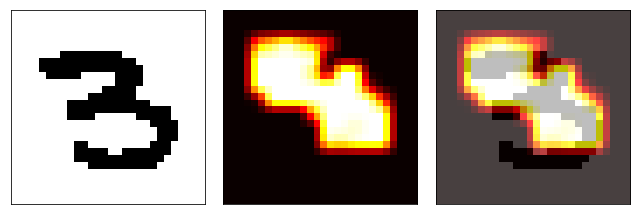

Test image 9:


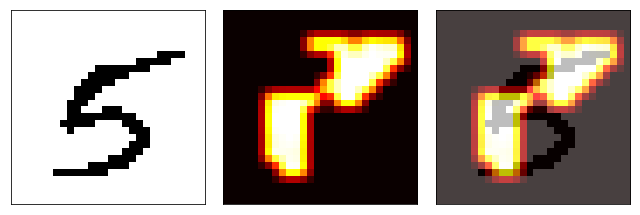

Test image 10:


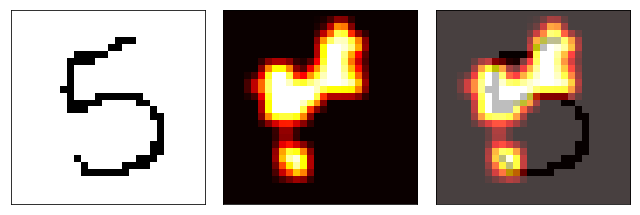

Test image 11:


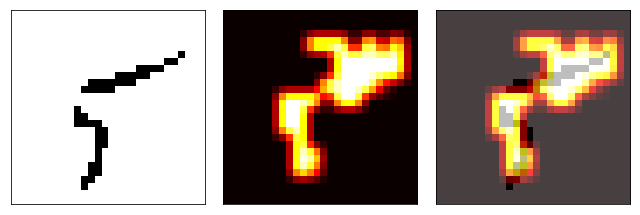

Test image 12:


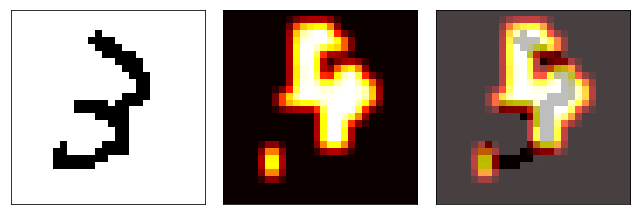

Test image 13:


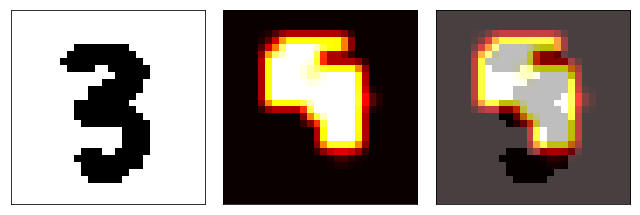

Test image 14:


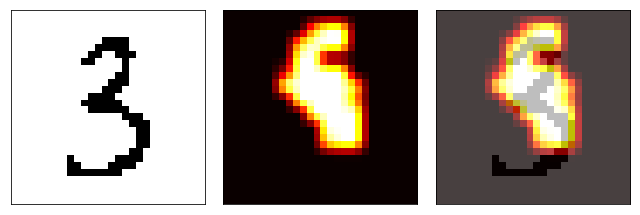

Test image 15:


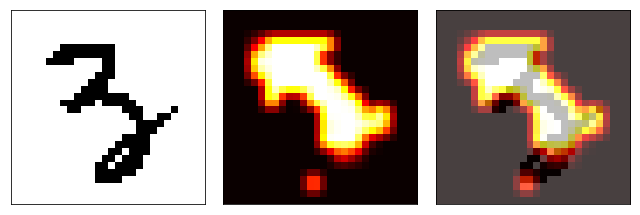

Test image 16:


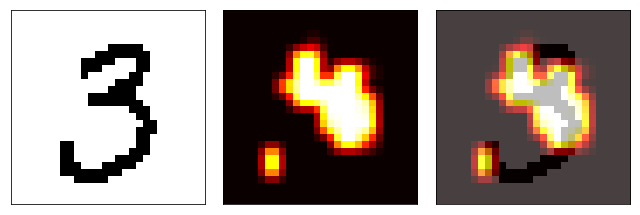

Test image 17:


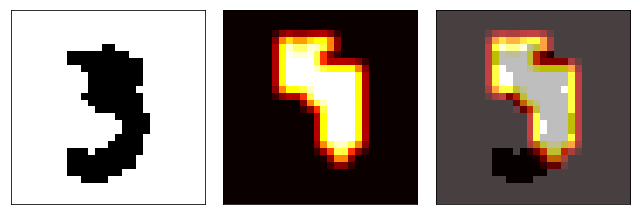

Test image 18:


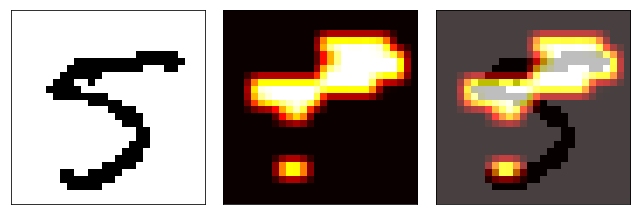

Test image 19:


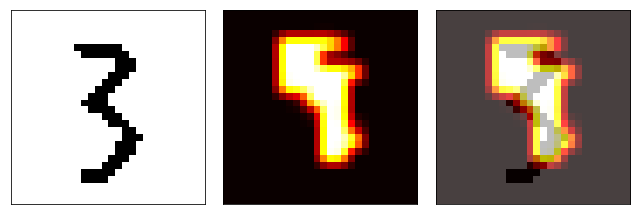

In [8]:
#Visualize a few images

for plot_i in range(0, 20) :
    
    print("Test image " + str(plot_i) + ":")
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 3, 3))

    ax1.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax1)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax2.imshow(importance_scores_test[plot_i, :, :, 0], cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax2)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax3.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    ax3.imshow(importance_scores_test[plot_i, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax3)
    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()
    plt.show()


In [9]:
#Save predicted importance scores

model_name = "pytorch_saliency_" + dataset_name + "_smaller_blur"

np.save(model_name + "_importance_scores_test", importance_scores_test)
